# Libary declaration

In [1]:
import tensorflow as tf
from tensorflow.keras import layers,models,datasets
import keras
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import random
from tensorflow.keras.layers import Activation, Dropout, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset load and class indentify

In [2]:
directory=r'D:\Tomatoo'#read main dataset
category=['Bacterial spot','Early blight','Healthy','Late blight','Leaf Mold','Mosaic virus','Septoria leaf spot','Spider mites','Target Spot','Yellow Leaf Curl Virus'] # classes of dataset 1 step

# labeling dataset

In [3]:
img_size=224 # step 2
#no_of_image_to_show = 100
dataset=[]
for ctg in category: # ready for dataset training and Testing 
    folder=os.path.join(directory, ctg)
    classes=category.index(ctg)
    for img in os.listdir(folder):
        try:
            img_array=cv2.imread(os.path.join(folder,img))
            new_array=cv2.resize(img_array, (img_size,img_size))
            dataset.append([new_array,classes])
        except Exception as e:
            pass

In [4]:
random.shuffle(dataset)

In [5]:
len(dataset)

10000

In [6]:
X=[] # step 4
Y=[]
for features,label in dataset:
    X.append(features)
    Y.append(label)

# Converting into array

In [7]:
X=np.array(X) # step 5
Y=np.array(Y)

# Separting dataset for traning and testing

In [9]:
from sklearn.model_selection import train_test_split # step 6
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state =15)#test_size=0.2#shuffle=True

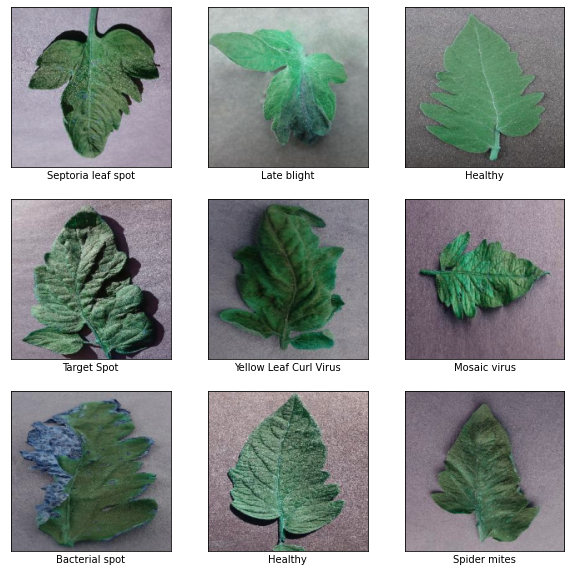

In [10]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i],cmap=plt.cm.binary)
    plt.xlabel(category[y_train[i]])
plt.show()

In [11]:
print('Train', x_train.shape, y_train.shape)
print('Validation', x_test.shape, y_test.shape)

Train (8000, 224, 224, 3) (8000,)
Validation (2000, 224, 224, 3) (2000,)


# Data Augmentation

In [12]:
datagen = ImageDataGenerator(
      #featurewise_center=True,
      #samplewise_center=True,
      #featurewise_std_normalization=True,
      #samplewise_std_normalization=True,
      #zca_whitening=True,
      rotation_range=90,
      rescale=1./255,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.5,
      zoom_range=0.5,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest'
)

In [13]:
#aug
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

batch_size = 48
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)

In [14]:
datagen_valid = ImageDataGenerator(
  rescale = 1. / 255,
)

x_valid = x_train[:25*batch_size]
y_valid = y_train[:25*batch_size]

x_valid.shape[0]
# y_valid.shape[0]

1200

In [15]:
valid_steps = x_valid.shape[0] // batch_size
validation_generator = datagen_valid.flow(x_valid, y_valid, batch_size=batch_size)

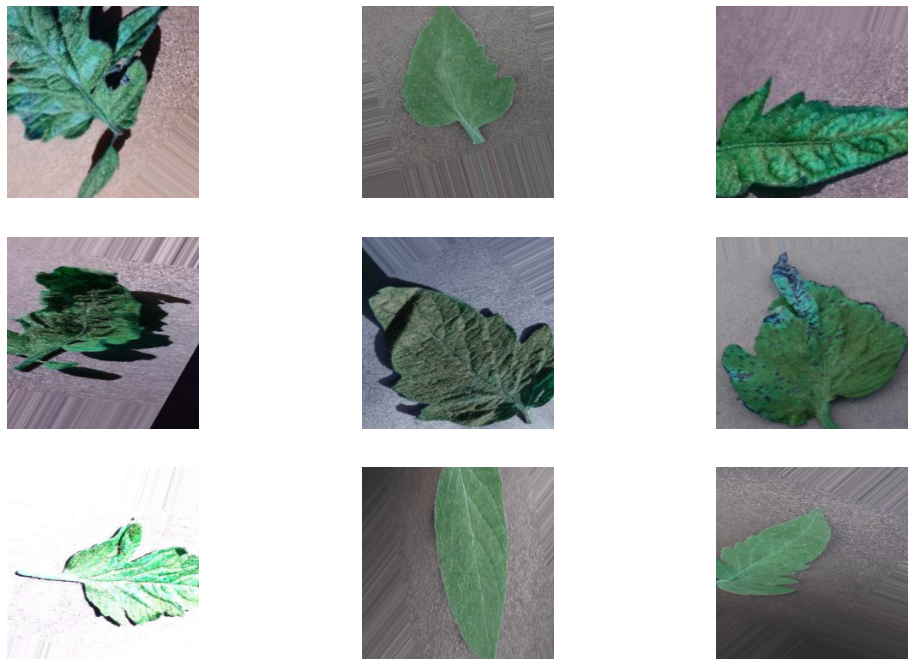

In [17]:
figure = plt.figure()
i = 0
for x_batch, y_batch in datagen.flow(x_train, y_train):
    a = figure.add_subplot(3, 3, i + 1)
    plt.imshow(x_batch[i].reshape(224, 224, 3))
    a.axis('off')
    if i == 8: break
    i += 1
figure.set_size_inches(np.array(figure.get_size_inches()) * 3)
plt.show()

# CNN Model

In [18]:
model = models.Sequential() # model 
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size,img_size, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10,activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       7

In [ ]:
# learning_rate = 0.001
# epochs=120
# opt= tf.keras.optimizers.Adam(learning_rate=learning_rate , decay=learning_rate/(epochs*0.5))

In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
#history = model.fit(x_batches,y_batches, epochs=80,validation_data=(x_test, y_test))#, validation_data=(x_test, y_test),datagen.flow(x_train,y_train,batch_size=10)
history = model.fit(
  train_generator,
  steps_per_epoch=len(x_train) // batch_size,
  epochs=120,
  # batch_size=10,
  validation_data=validation_generator,
  validation_freq=1,
  validation_steps=valid_steps,
  verbose=2
)
# history = model.fit(train_generator,epochs=120,validation_data=(x_test, y_test))

Epoch 1/120
166/166 - 312s - loss: 2.0763 - accuracy: 0.2140 - val_loss: 1.6325 - val_accuracy: 0.4250
Epoch 2/120
166/166 - 283s - loss: 1.4814 - accuracy: 0.4537 - val_loss: 1.2387 - val_accuracy: 0.5483
Epoch 3/120
166/166 - 282s - loss: 1.1918 - accuracy: 0.5743 - val_loss: 1.1928 - val_accuracy: 0.5875
Epoch 4/120
166/166 - 291s - loss: 0.9976 - accuracy: 0.6484 - val_loss: 1.1898 - val_accuracy: 0.6092
Epoch 5/120
166/166 - 300s - loss: 0.8710 - accuracy: 0.6997 - val_loss: 0.8162 - val_accuracy: 0.7033
Epoch 6/120
166/166 - 317s - loss: 0.7967 - accuracy: 0.7157 - val_loss: 0.8559 - val_accuracy: 0.7142
Epoch 7/120
166/166 - 288s - loss: 0.7292 - accuracy: 0.7504 - val_loss: 0.5943 - val_accuracy: 0.8000
Epoch 8/120
166/166 - 283s - loss: 0.6315 - accuracy: 0.7801 - val_loss: 0.6423 - val_accuracy: 0.7767
Epoch 9/120
166/166 - 286s - loss: 0.6294 - accuracy: 0.7841 - val_loss: 0.5459 - val_accuracy: 0.8117
Epoch 10/120
166/166 - 288s - loss: 0.5384 - accuracy: 0.8151 - val_loss:

Epoch 80/120
166/166 - 306s - loss: 0.1282 - accuracy: 0.9584 - val_loss: 0.0878 - val_accuracy: 0.9667
Epoch 81/120
166/166 - 309s - loss: 0.1336 - accuracy: 0.9557 - val_loss: 0.0873 - val_accuracy: 0.9742
Epoch 82/120
166/166 - 285s - loss: 0.1365 - accuracy: 0.9552 - val_loss: 0.0571 - val_accuracy: 0.9842
Epoch 83/120
166/166 - 304s - loss: 0.1155 - accuracy: 0.9594 - val_loss: 0.0474 - val_accuracy: 0.9825
Epoch 84/120
166/166 - 287s - loss: 0.1295 - accuracy: 0.9599 - val_loss: 0.0566 - val_accuracy: 0.9808
Epoch 85/120
166/166 - 284s - loss: 0.1242 - accuracy: 0.9591 - val_loss: 0.1036 - val_accuracy: 0.9733
Epoch 86/120
166/166 - 284s - loss: 0.1603 - accuracy: 0.9499 - val_loss: 0.0560 - val_accuracy: 0.9783
Epoch 87/120
166/166 - 286s - loss: 0.1148 - accuracy: 0.9632 - val_loss: 0.0768 - val_accuracy: 0.9717
Epoch 88/120
166/166 - 285s - loss: 0.1163 - accuracy: 0.9615 - val_loss: 0.0510 - val_accuracy: 0.9792
Epoch 89/120
166/166 - 292s - loss: 0.1092 - accuracy: 0.9633 - 

# Evaluation and Accuracy report with confusion matrix

In [1]:
x_final_test = x_test / 255.0
eval = model.evaluate(x_final_test, y_test)

NameError: name 'x_test' is not defined

In [20]:
y_test=np.argmax(y_test, axis=1)
y_test[1]

7

In [22]:
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
y_pred=model.predict(x_final_test)
y_pred_class=[np.argmax(element) for element in y_pred]
cm=confusion_matrix(y_test,y_pred_class)
print("confusion matrix: \n",cm)
print("Classification Report: \n",classification_report(y_test,y_pred_class))

confusion matrix: 
 [[184   3   1   0   0   0   1   0   7   0]
 [  0 194   0   1   0   0   0   4   0   0]
 [  0   0 206   0   1   1   0   0   0   0]
 [  1   1   0 190   0   0   3   0   0   1]
 [  0   0   0   0 199   0   4   3   0   0]
 [  0   0   0   0   0 207   0   0   0   0]
 [  0   0   0   1   0   1 179   0   0   0]
 [  0   0   0   0   0   1   0 192   0   0]
 [  0   1   1   0   0   0   0   2 212   0]
 [  5   0   0   0   0   0   0   0   0 193]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.94      0.95       196
           1       0.97      0.97      0.97       199
           2       0.99      0.99      0.99       208
           3       0.99      0.97      0.98       196
           4       0.99      0.97      0.98       206
           5       0.99      1.00      0.99       207
           6       0.96      0.99      0.97       181
           7       0.96      0.99      0.97       193
           8       0.97      0.98    

# Confusion matrix Graph

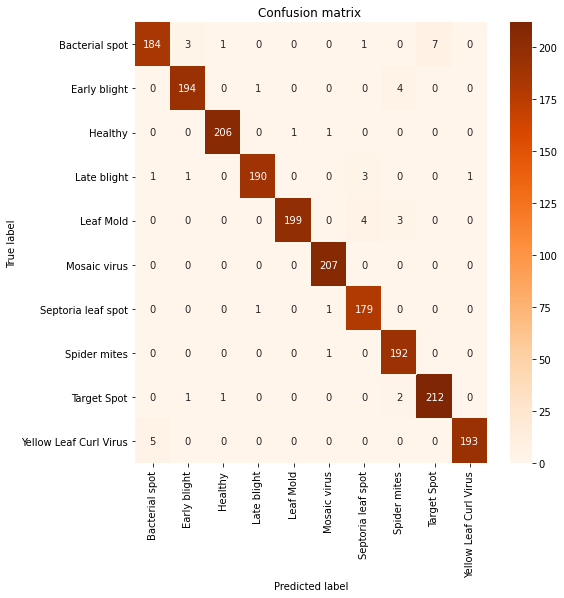

In [29]:
cm = pd.DataFrame(cm,index = category, 
                     columns = category)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(cm,annot=True,cmap=plt.cm.Oranges,fmt='d')
plt.tight_layout()
plt.title('Confusion matrix ')
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig("D:\Vehicle\img222.png")
plt.show()

# Traning and Validation loss graph

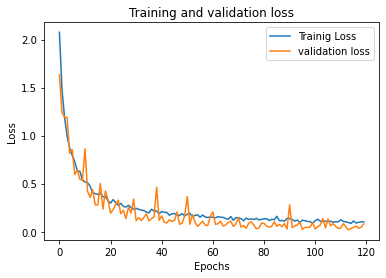

In [25]:
#model.evaluate(x_test,y_test,batch_size=32, verbose=1)
plt.plot(history.history['loss'],label='Trainig Loss')
plt.plot(history.history['val_loss'],label="validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
#plt.savefig("D:\Vehicle\img1.png")
plt.show()

In [ ]:
x_test.shape

In [ ]:
x_train.shape

# Traning and Validation Accuracy graph

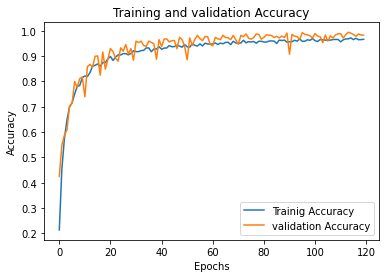

In [26]:
#model.evaluate(x_test,y_test,batch_size=32, verbose=1)
plt.plot(history.history['accuracy'],label='Trainig Accuracy')
plt.plot(history.history['val_accuracy'],label="validation Accuracy")
plt.title("Training and validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
#plt.savefig("D:\Vehicle\img2.png")
plt.show()

# Actual and Prediction Graph

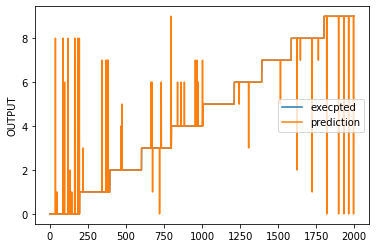

In [27]:
def chart_regression(pred,y,sort=True):
    t=pd.DataFrame({'pred':pred,'y':y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    plt.plot(t['y'].tolist(),label='execpted')
    plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('OUTPUT')
    plt.legend()
    plt.savefig("cnn.png")
    plt.show()
y_test1 = np.array(list(y_test))
y_pred1 = np.array(y_pred_class)
chart_regression(y_pred1.flatten(),y_test1)